# Detection Mistakenness with FiftyOne

Finding mistakes in your annotations can be extremely tedious. The mistakenness feature of FiftyOne can be used to help you find annotation mistakes. Check out [our classification tutorial](https://voxel51.com/docs/fiftyone/tutorials/label_mistakes.html) to see how FiftyOne can help you find and correct label mistakes in your classification datasets.

This recipe demonstrates the use of the FiftyOne Brain's [mistakenness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#label-mistakes) on your detection dataset, enabling you to curate higher quality datasets and, ultimately, train better models!

## Overview

In this recipe, we explore how FiftyOne can be used to help you find mistakes in your detection annotations using the FiftyOne Brain's [mistakenness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#label-mistakes).

**Requirements**

- A detection model trained on the same label schema as the annotations you want to analyze
- A FiftyOne Dataset with your annotations and predictions with confidence from the model (with optional logits for each detection)
- It is recommended to use logits for each prediction, however, since these can be hard to come by you can compute mistakenness with just confidence for each prediction by passing the `use_logits = False` argument when calling `compute_mistakenness()`

**Concepts**

-   Computing insights into your detection dataset relating to possible mistakes
-   Visualizing mistakes in the FiftyOne App

## Setup

If you haven't already, install FiftyOne:

In [ ]:
!pip install fiftyone

Your Dataset should have two [detections fields](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#object-detection), one with your ground truth annotations and one with your model predictions.

In this example, we'll load the `quickstart` dataset from the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/zoo.html), which has ground truth annotations and predictions from a [PyTorch Faster-RCNN model](https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py) for a few samples from the COCO dataset.

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("quickstart")
print(dataset)

Dataset already downloaded
Loading 'quickstart'
 100% |█████████████████████| 200/200 [3.8s elapsed, 0s remaining, 40.7 samples/s]      
Dataset 'quickstart' created
Name:           quickstart
Media type:     image
Num samples:    200
Persistent:     False
Info:           {}
Tags:           ['validation']
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:   fiftyone.core.fields.FloatField
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [2]:
sample = dataset.first()
print(sample.predictions.detections[0])

<Detection: {
    'id': '5f452c60ef00e6374aad9394',
    'attributes': BaseDict({}),
    'label': 'bird',
    'bounding_box': BaseList([
        0.22192673683166503,
        0.06093006531397502,
        0.4808845520019531,
        0.8937615712483724,
    ]),
    'mask': None,
    'confidence': 0.9750854969024658,
    'index': None,
}>



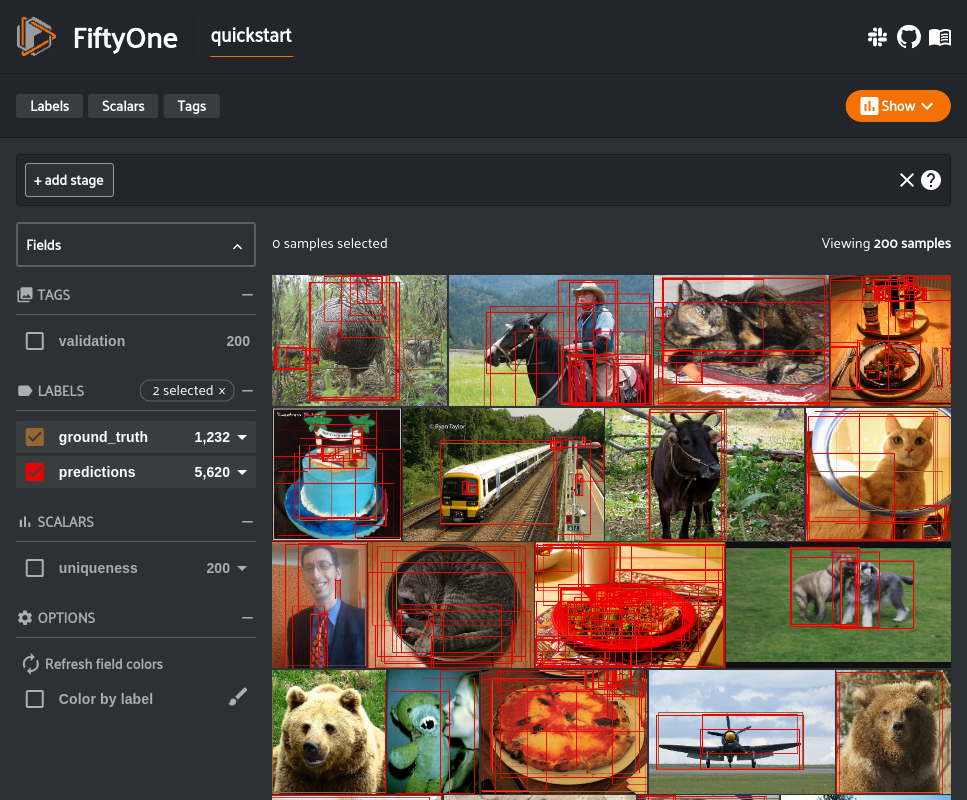

In [3]:
# Open the dataset in the App
session = fo.launch_app(dataset)

## Compute mistakenness

Now we're ready to assess the mistakenness of the ground truth detections.

We can do so by running the [compute_uniqueness()](https://voxel51.com/docs/fiftyone/api/fiftyone.brain.html#fiftyone.brain.compute_mistakenness) method from the FiftyOne Brain.

> **NOTE:** It is recommended to add logits to each detection. However, if your dataset doesn't have them
> you can specify `use_logits = False`. Since we don't have logits in this example, we'll do this.

In [4]:
import fiftyone.brain as fob

# Compute mistakenness of annotations in `ground_truth` field using 
# predictions from `predictions` field as point of reference
fob.compute_mistakenness(
    dataset, "predictions", label_field="ground_truth", use_logits=False
)

Evaluating detections...
 100% |█████████████████████| 200/200 [4.2s elapsed, 0s remaining, 32.9 samples/s]      
Computing mistakenness...
 100% |█████████████████████| 200/200 [3.6s elapsed, 0s remaining, 42.0 samples/s]      
Mistakenness computation complete


The above method added fields to all samples for which we had predictions at both a sample and detection level. Specifically, it added the following.

Ground truth detections (`ground_truth` field):

- `mistakenness`: A measure of the correctness of the detection and classification of the object therein.(When ground truth and predicted detections are matched)
- `mistakenness_loc`: A measure of the mistakenness of the localization (bounding box) of a ground truth object. (When ground truth and predicted detections are matched)
- `possible_spurious`: If the ground truth object was not matched with a prediction, it is flagged as a possible mistake

New ground truth predictions (`ground_truth` field):

- `possible_missing`: If a highly confidence prediction with no matching ground truth object is encountered, it is added to the ground truth objects with this flag populated to indicate that it is a likely missing annotation

Sample-level fields:

- `mistakenness`: The maximum mistakenness of all ground truth detections with matching predictions
- `possible_spurious`: The number of possible spurious detections across the ground truth annotations in the sample
- `possible_missing`: The number of possible missing detections deduced and added to the  all highly confident predictions in the sample

## Analyzing the results

Let's use FiftyOne to investigate the results.

First, let's show the samples with the most likely annotation mistakes:

In [5]:
from fiftyone import ViewField as F

# Sort by likelihood of mistake (most likely first)
mistake_view = dataset.sort_by("mistakenness", reverse=True)

# Print some information about the view
print(mistake_view)

Dataset:        quickstart
Media type:     image
Num samples:    200
Tags:           ['validation']
Sample fields:
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:        fiftyone.core.fields.FloatField
    predictions:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    mistakenness:      fiftyone.core.fields.FloatField
    possible_missing:  fiftyone.core.fields.IntField
    possible_spurious: fiftyone.core.fields.IntField
View stages:
    1. SortBy(field_or_expr='mistakenness', reverse=True)


In [6]:
# Inspect some samples and detections
# This is the first detection of the first sample
print(mistake_view.first().ground_truth.detections[0])

<Detection: {
    'id': '5f452487ef00e6374aad2744',
    'attributes': BaseDict({
        'area': <NumericAttribute: {'value': 16273.3536}>,
        'iscrowd': <NumericAttribute: {'value': 0.0}>,
    }),
    'label': 'tv',
    'bounding_box': BaseList([
        0.002746666666666667,
        0.36082,
        0.24466666666666667,
        0.3732,
    ]),
    'mask': None,
    'confidence': None,
    'index': None,
    'predictions_eval': BaseDict({
        'matches': BaseDict({
            '0_5': BaseDict({
                'pred_id': '5f452c65ef00e6374aadd6c2',
                'iou': 0.9171496791329676,
            }),
        }),
    }),
    'mistakenness_loc': 0.16955941131917984,
    'mistakenness': 0.005771428346633911,
}>


Let's use the App to visually inspect the results:


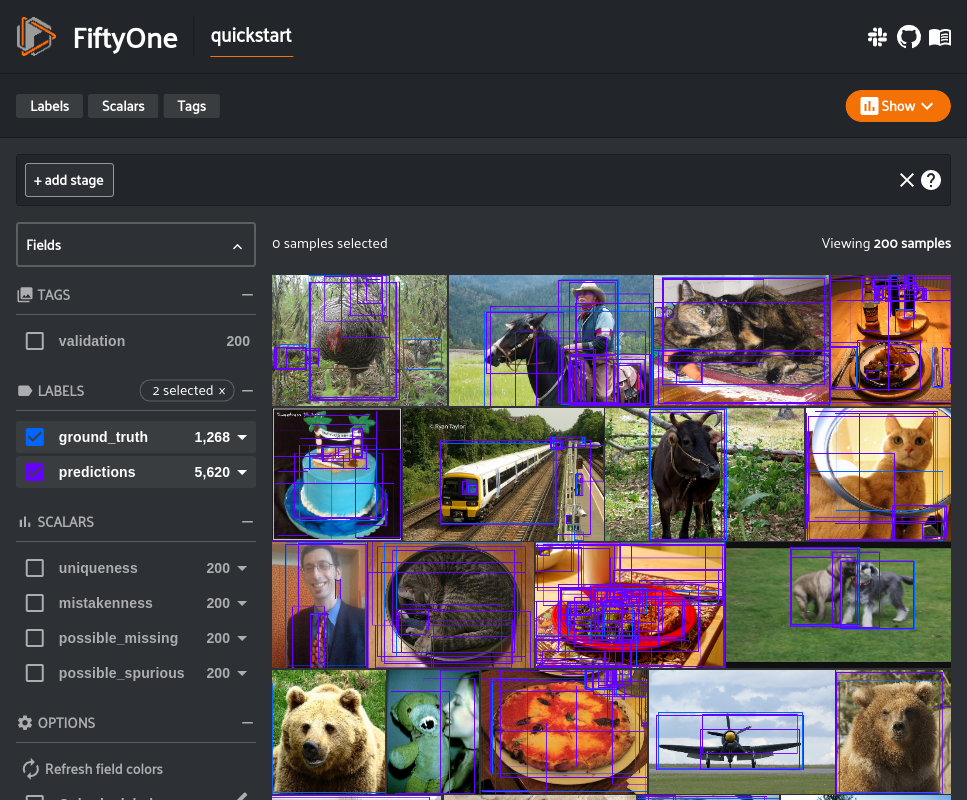

In [7]:
# Refresh App to show new sample fields
session.refresh()


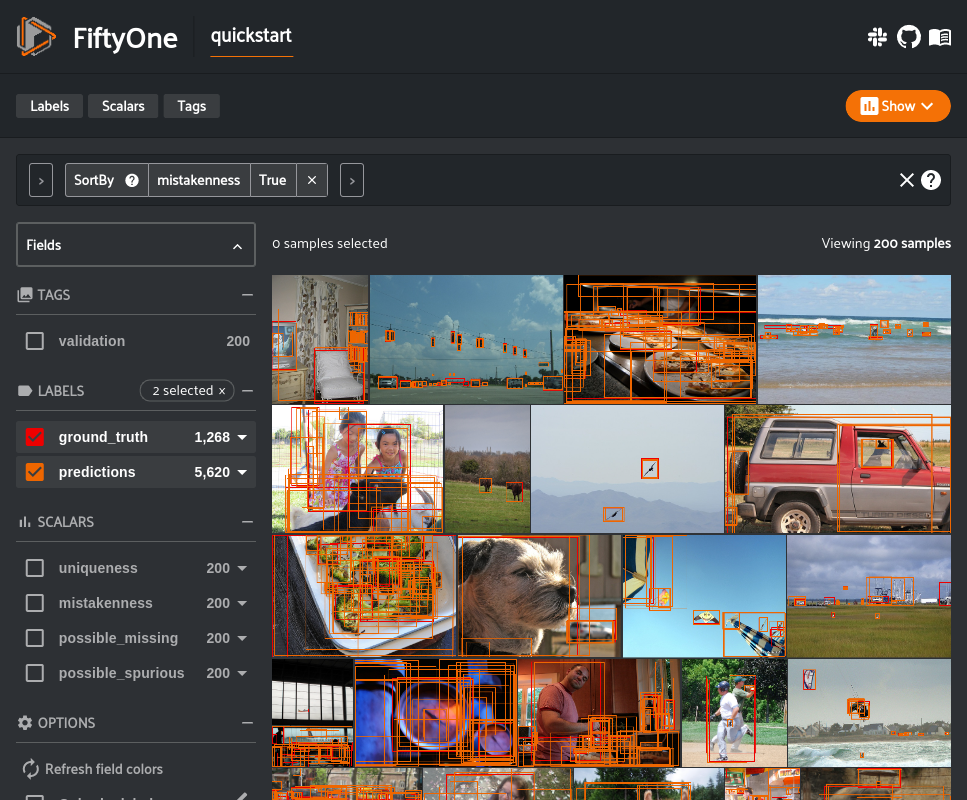

In [8]:
# Show the samples we processed in rank order by the mistakenness
session.view = mistake_view

Another useful query is to find all objects that have a high mistakenness, lets say > 0.95:


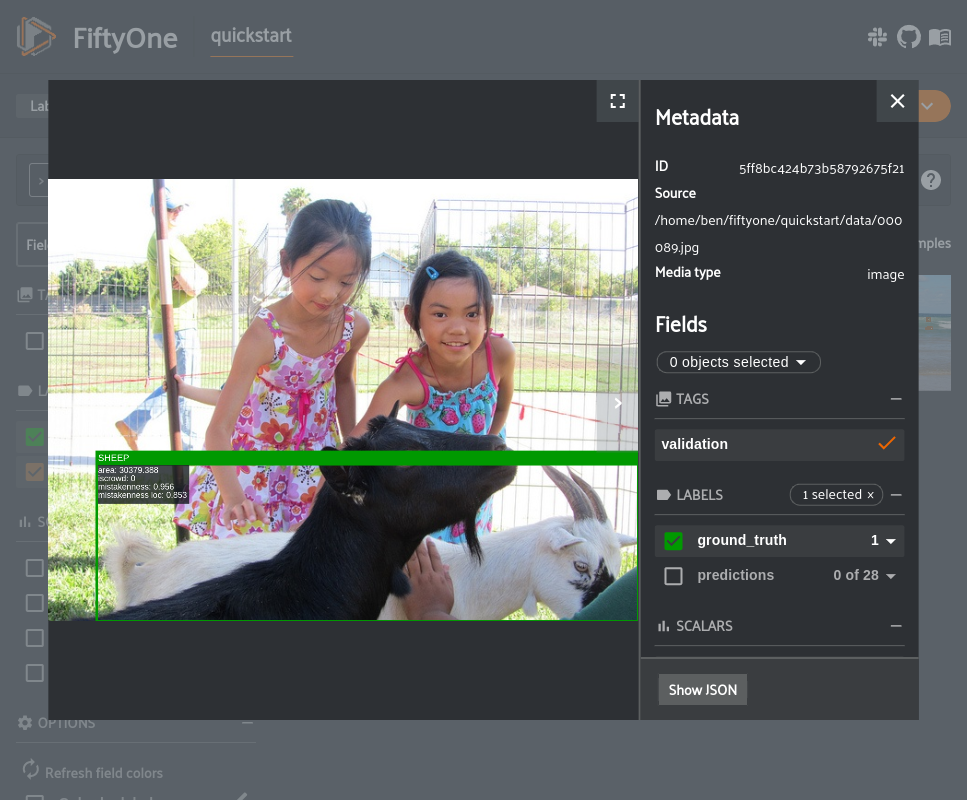

In [9]:
from fiftyone import ViewField as F

high_mistake_view = dataset.filter_detections(
    "ground_truth", F("mistakenness") > 0.95, only_matches=True
)

session.view = high_mistake_view

Looking through the results, we see some annotations that may be incorrect. For example, in the image below the `goat` is labeled as a `sheep`.

We can use a similar workflow to look at objects that may be localized poorly.


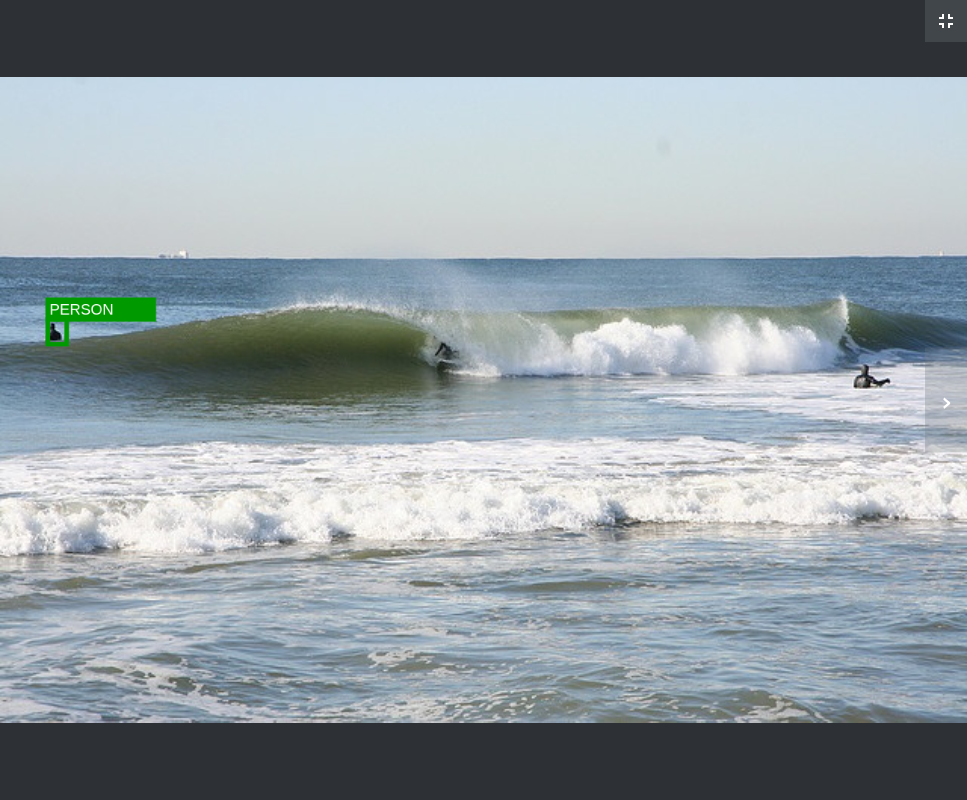

In [10]:
loose_boxes_view = dataset.filter_detections(
    "ground_truth", F("mistakenness_loc") > 0.95, only_matches=True
)

session.view = loose_boxes_view

One of the examples that popped up from this query is shown below. The bounding box around the person on the left side of the image is shifted too far to the right.

The `possible_missing` field can also be useful to sort by to find instances of incorrect annotations.

Similarly, `possible_spurious` can be used to find objects that the model detected that may have been missed by annotators.


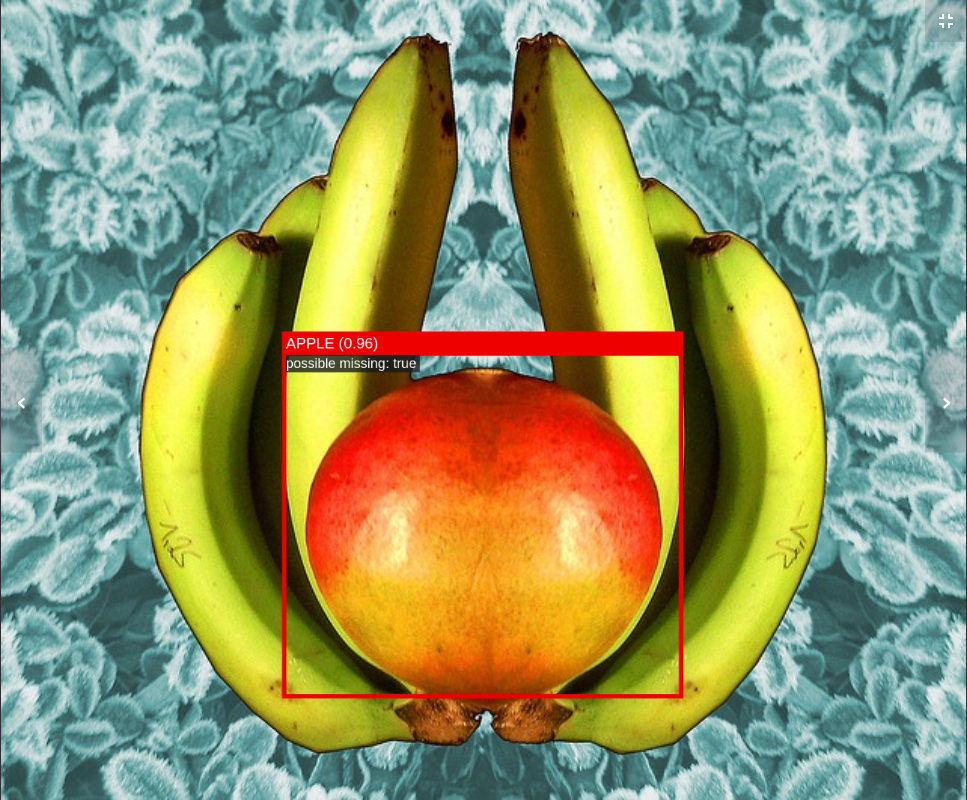

In [11]:
session.view = dataset.match(F("possible_missing") > 0)

An example that showed up from this search is shown above. There is an `apple` that was not annotated that the model detected.

> **REMEMBER**: Since you are using model predictions to guide the mistakenness process, the better your model,
> the more accurate the mistakenness suggestions. Additionally, using logits of confidence scores will also
> provide better results. 

We used Faster-RCNN in this example which is quite a few years old. Using EfficientDet D7 provided much better results. For example, it was easily able to find this `snowboard` labeled as `skis`:

![skis](images/det_mistakenness_6.png)

In [12]:
session.freeze() # screenshot the active App for sharing